In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential # type: ignore
from keras.layers import Input, Embedding , Flatten, Concatenate # type: ignore
from keras.models import Model # type: ignore
from keras.optimizers import Adam # type: ignore
from keras.layers import Dense, Dropout, Activation , BatchNormalization # type: ignore
from tensorflow.keras.preprocessing.sequence import pad_sequences # type: ignore

from keras.layers import Lambda # type: ignore

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


from wordcloud import WordCloud
from scipy.sparse.linalg import svds
from IPython.display import SVG


### Data visualisation

In [20]:
#gathering data from the dataset

movies = pd.read_csv('dataset/movies.dat' , sep='::' , engine='python' , encoding='latin-1' , header=None)
movies.columns = ['movie_id' , 'title' , 'genres']

ratings = pd.read_csv('dataset/ratings.dat' , sep='::' , engine='python' , encoding='latin-1' , header=None)
ratings.columns = ['user_id' , 'movie_id' , 'rating' , 'timestamp']

users = pd.read_csv('dataset/users.dat' , sep='::' , engine='python' , encoding='latin-1' , header=None)
users.columns = ['user_id','gender','age','occupation','zip_code']

In [21]:
print(movies.shape , ratings.shape , users.shape)

(3883, 3) (1000209, 4) (6040, 5)


In [22]:
print(movies.isnull().sum())  # Check for missing values in movies DataFrame
print(ratings.isnull().sum())  # Check for missing values in ratings DataFrame
print(users.isnull().sum())  # Check for missing values in users DataFrame

movie_id    0
title       0
genres      0
dtype: int64
user_id      0
movie_id     0
rating       0
timestamp    0
dtype: int64
user_id       0
gender        0
age           0
occupation    0
zip_code      0
dtype: int64


In [23]:
print(ratings.duplicated().sum())  # Check for duplicate rating records
print(movies.duplicated().sum())   # Check for duplicate movie records
print(users.duplicated().sum())    # Check for duplicate user records

0
0
0


In [24]:
#merging the dataframes movies and ratings on the basis of movie_id aggregate the ratings of each movie
movie_ratings = pd.merge(movies , ratings , on='movie_id')
movie_ratings_mean = movie_ratings.groupby('title').agg({'rating':[np.size,np.mean]})
movie_ratings.head()

,movie_id,title,genres,user_id,rating,timestamp
0,1,Toy Story (1995),Animation|Children's|Comedy,1,5,978824268
1,1,Toy Story (1995),Animation|Children's|Comedy,6,4,978237008
2,1,Toy Story (1995),Animation|Children's|Comedy,8,4,978233496
3,1,Toy Story (1995),Animation|Children's|Comedy,9,5,978225952
4,1,Toy Story (1995),Animation|Children's|Comedy,10,5,978226474


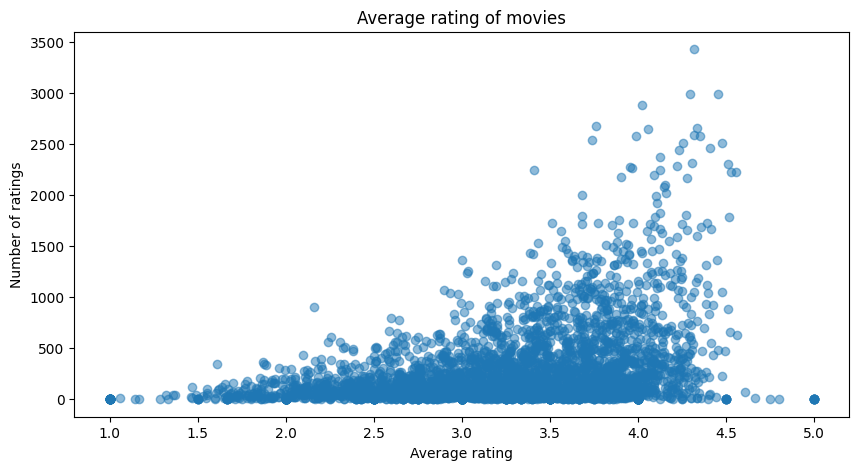

In [25]:
#plot the average rating scatter plot
plt.figure(figsize=(10,5))
plt.title('Average rating of movies')
plt.scatter(movie_ratings_mean[('rating','mean')] , movie_ratings_mean[('rating','size')] , alpha=0.5)
plt.xlabel('Average rating')
plt.ylabel('Number of ratings')
plt.show()


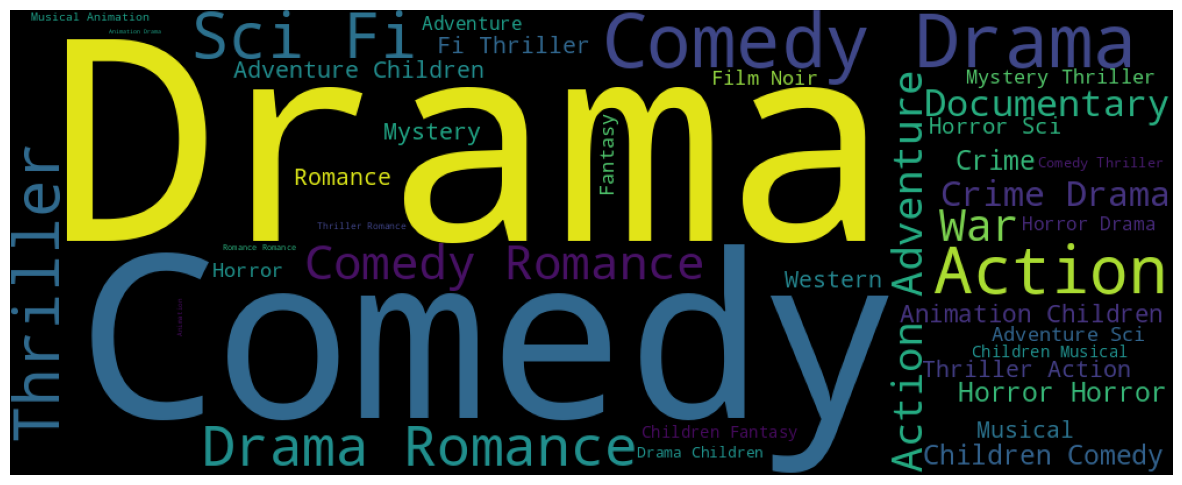

In [26]:
#show the relationship between the average rating and genre
genres = set()
for genre in movies.genres.str.split('|').values:
    genres = genres.union(set(genre))
genres = list(genres)

#display wordcloud of genres
genre_wordcloud = WordCloud(width=1000,height=400).generate(' '.join(movies['genres']))
plt.figure(figsize=(15,10))
plt.imshow(genre_wordcloud)
plt.axis('off')
plt.show()

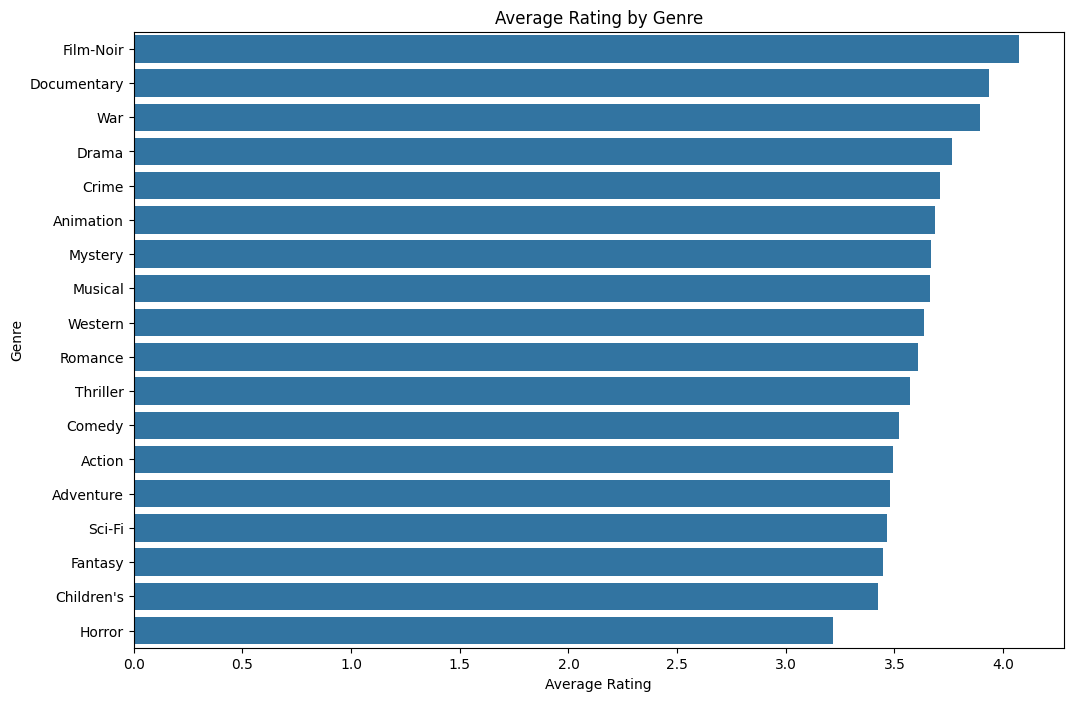

In [27]:
#merge movies and ratings dataframes on the basis of genre and aggregate the ratings of each genre

movies_exploded = movies.copy()
movies_exploded['genre'] = movies_exploded['genres'].str.split('|')
movies_exploded = movies_exploded.explode('genre')

# Step 3: Merge with ratings DataFrame on movieId
merged_data = pd.merge(movies_exploded[['movie_id', 'genre']], ratings[['movie_id', 'rating']], on='movie_id')

# Step 4: Calculate the average rating for each genre
genre_ratings = merged_data.groupby('genre')['rating'].mean().reset_index()
genre_ratings.columns = ['genre', 'average_rating']

genre_ratings_sorted = genre_ratings.sort_values(by='average_rating', ascending=False)

# Display the average rating per genre in a bar chart top to bottom sorted
plt.figure(figsize=(12, 8))
sns.barplot(x='average_rating', y='genre', data=genre_ratings_sorted)
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.title('Average Rating by Genre')
plt.show()


## Data Preprocessing

In [39]:
#use Label encoding to encode the genres
le = LabelEncoder()
le.fit(genres)

# Step 3: Apply label encoding to each genre in 'movies' DataFrame
movies_encoded = movie_ratings.copy()
# Encode each genre in the 'genres' column
movies_encoded['genres_encoded'] = movies_encoded['genres'].apply(
    lambda x: le.transform(x.split('|')).tolist()  # Split, encode, and store as a list
)

max_genre = movies_encoded['genres_encoded'].apply(lambda x: len(x)).max()

#convert timestamp to datetime
movies_encoded['timestamp'] = pd.to_datetime(movie_ratings['timestamp'], unit='s')
print(len(movies_encoded['timestamp']))

movies_encoded.head(10)

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

In [29]:

train_data, test_data = train_test_split(movies_encoded, test_size=0.2, random_state=42)

print(train_data.shape, test_data.shape)

(800167, 7) (200042, 7)


## Matrix Factorisation 

In [30]:
def create_enhanced_model(num_users, num_movies, num_genres, max_genres_per_movie=5, embedding_dim=1000):
    user_input = Input(shape=(1,), name='user_input')
    movie_input = Input(shape=(1,), name='movie_input')
    genre_input = Input(shape=(max_genres_per_movie,), name='genre_input')
    year_input = Input(shape=(1,), name='year_input')  # Release year input

    # User embedding
    user_embedding = Embedding(
        input_dim=num_users,
        output_dim=embedding_dim,
        embeddings_initializer='he_normal',
        name='user_embedding'
    )(user_input)

    # Movie embedding
    movie_embedding = Embedding(
        input_dim=num_movies,
        output_dim=embedding_dim,
        embeddings_initializer='he_normal',
        name='movie_embedding'
    )(movie_input)

    # Genre embedding
    genre_embedding = Embedding(
        input_dim=num_genres + 1,
        output_dim=embedding_dim ,
        embeddings_initializer='he_normal',
        name='genre_embedding',
        mask_zero=True
    )(genre_input)

    # Flatten embeddings
    user_vector = Flatten()(user_embedding)
    movie_vector = Flatten()(movie_embedding)
    
    
    year_embedding = Dense(embedding_dim , activation='relu')(year_input)

    # Combine all features
    concat = Concatenate()([
        user_vector,
        movie_vector,
        genre_vector,
        year_embedding
    ])

    # Dense layers
    x = Dense(128, activation='relu')(concat)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Dense(64, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    x = Dense(32, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    # Output layer
    output = Dense(1, activation='sigmoid')(x)

    # Create model
    model = Model(
        inputs=[user_input, movie_input, genre_input, year_input],
        outputs=output
    )

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
        loss='mean_squared_error',
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )

    return model

In [31]:
def extract_year(movie_name):
    try:
        start = movie_name.rindex('(')
        end = movie_name.rindex(')')
        year = int(movie_name[start + 1:end])
        return year
    except (ValueError, IndexError):
        return None

In [32]:
def prepare_data_for_model(train_data , max_genres = 5):
    
    
    # Extract a subarray of the DataFrame X_train containing the relevant columns
    users_ids = train_data['user_id']
    movies_ids = train_data['movie_id']
    ratings = train_data['rating']

    padded_genres = pad_sequences(train_data['genres_encoded'], maxlen=max_genres, padding='post')

    title = train_data['title']
    years = [extract_year(name) for name in title]
    min_year = min(years)
    normalized_years = [[year - min_year] for year in years]  # Normalize years
    
    return (    
        np.array(users_ids),
        np.array(movies_ids),
        np.array(ratings),
        np.array(padded_genres),
        np.array(normalized_years)
    )    

In [33]:
num_users = max(movies_encoded['user_id'])+1
num_movies = max(movies_encoded['movie_id'])+1
num_genres = len(genres)

print(num_users, num_movies, num_genres)

# Create model
model = create_enhanced_model(num_users, num_movies, num_genres, embedding_dim=50)

# Prepare data for model
users_idx, movies_idx, ratings, genres_enc, timestamps = prepare_data_for_model(train_data)

#print max value of movies_idx
print(max(movies_idx))
print(min(movies_idx))

6041 3953 18
3952
1


In [34]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_input         │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 50)     │    302,050 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 50)     │    197,650 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genre_embedding     │ (None, 5, 25)     │        475 │ genre_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_1         │ (None, 5)         │          0 │ genre_input[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ year_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 50)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 50)        │          0 │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 25)        │          0 │ genre_embedding[… │
│                     │                   │            │ not_equal_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 12)        │         24 │ year_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 137)       │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ flatten_3[0][0],  │
│                     │                   │            │ lambda_1[0][0],   │
│                     │                   │            │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     17,664 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_5[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                 

 Total params: 529,128 (2.02 MB)

 Trainable params: 528,680 (2.02 MB)

 Non-trainable params: 448 (1.75 KB)

In [35]:
history = model.fit(
    [users_idx, movies_idx, genres_enc, timestamps],
    ratings,
    batch_size=64,
    epochs=40,
    validation_split=0.2,
    shuffle=True,
    verbose=1
)

Epoch 1/40
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 32s 3ms/step - loss: 7.9619 - mae: 2.5895 - rmse: 2.8215 - val_loss: 7.9140 - val_mae: 2.5824 - val_rmse: 2.8132
Epoch 2/40
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 7.9199 - mae: 2.5830 - rmse: 2.8142 - val_loss: 7.9140 - val_mae: 2.5824 - val_rmse: 2.8132
Epoch 3/40
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 7.9227 - mae: 2.5832 - rmse: 2.8147 - val_loss: 7.9140 - val_mae: 2.5824 - val_rmse: 2.8132
Epoch 4/40
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 7.9160 - mae: 2.5822 - rmse: 2.8135 - val_loss: 7.9140 - val_mae: 2.5824 - val_rmse: 2.8132
Epoch 5/40
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 7.9223 - mae: 2.5838 - rmse: 2.8147 - val_loss: 7.9140 - val_mae: 2.5824 - val_rmse: 2.8132
Epoch 6/40
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 7.9173 - mae: 2.5823 - rmse: 2.8138 - val_loss: 7.9140 - val_mae: 2.5824 - val_rmse: 2.8132
Epoch 7/40
10003/10003 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step -

In [36]:
def test_model(test_data):
    users, movies, ratings ,genres_enc , timestamps = prepare_data_for_model(test_data)

    predictions = model.predict([users, movies, genres_enc, timestamps])
    return predictions

predictions = test_model(test_data)

# Calculate RMSE
rmse = np.sqrt(np.mean((predictions.flatten() - test_data['rating'])**2))
print(f'RMSE: {rmse:.2f}')


6252/6252 ━━━━━━━━━━━━━━━━━━━━ 5s 758us/step
RMSE: 2.81
